In [57]:
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, average_precision_score
import optuna
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
X_train = pd.read_csv('../output/split-dataset/X_train.csv')
y_train = pd.read_csv('../output/split-dataset/y_train.csv')
X_validation = pd.read_csv('../output/split-dataset/X_validation.csv')
y_validation = pd.read_csv('../output/split-dataset/y_validation.csv')
X_test = pd.read_csv('../output/split-dataset/X_test.csv')
y_test = pd.read_csv('../output/split-dataset/y_test.csv')

In [ ]:
categorical_features = [
    'transaction_type', 'merchant_category', 'location', 'device_used',
    'payment_channel', 'time_of_day', 'type_device_interaction',
    'channel_merchant_interaction'
]

for col in categorical_features:
    X_train[col] = X_train[col].astype('category')
    X_validation[col] = X_validation[col].astype('category')
    X_test[col] = X_test[col].astype('category')
    
y_train['is_fraud'] = y_train['is_fraud'].astype(int)
y_validation['is_fraud'] = y_validation['is_fraud'].astype(int)
y_test['is_fraud'] = y_test['is_fraud'].astype(int)

y_train = y_train['is_fraud']
y_validation = y_validation['is_fraud']
y_test = y_test['is_fraud']

## LightGBM

In [40]:
# Create LightGBM Dataset objects
train_data = lgb.Dataset(
    X_train, 
    label=y_train, 
    categorical_feature=categorical_features, 
    free_raw_data=False
)
validation_data = lgb.Dataset(
    X_validation, 
    label=y_validation, 
    categorical_feature=categorical_features,
    free_raw_data=False
)

# Define all parameters in a single dictionary
scale_pos_weight = y_train.value_counts().iloc[0] / y_train.value_counts().iloc[1]
params = {
    'objective': 'binary',
    'metric': 'auc',
    'scale_pos_weight': scale_pos_weight,
    'random_state': 42,
    'n_jobs': -1,
    'boosting_type': 'gbdt',
    'verbose': -1
}

# Train the model
print("Training LightGBM model with native API...")
model = lgb.train(
    params,
    train_set=train_data,
    num_boost_round=1000,
    valid_sets=[validation_data],
    valid_names=['validation'],
    callbacks=[lgb.early_stopping(100, verbose=True)]
)

print("\nModel training successful!")

Training LightGBM model with native API...
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	validation's auc: 0.610109

Model training successful!


In [42]:
# Predict probabilities on the test set
y_pred_proba = model.predict(X_test)

# Calculate metric scores
auc_roc = roc_auc_score(y_test, y_pred_proba)
auc_pr = average_precision_score(y_test, y_pred_proba)

print(f"Test Set AUC-ROC: {auc_roc:.4f}")
print(f"Test Set AUCPR (Average Precision): {auc_pr:.4f}")

Test Set AUC-ROC: 0.6095
Test Set AUCPR (Average Precision): 0.0458


In [ ]:
def objective(trial):
    # Hyperparameter search space
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1,
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 20, 30),
        
        # Core parameters for controlling complexity and learning
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        
        # Regularization and subsampling to prevent overfitting
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
    }

    # Train the model with the suggested hyperparameters
    model = lgb.LGBMClassifier(**params)
    
    model.fit(X_train, y_train,
              eval_set=[(X_validation, y_validation)],
              eval_metric='auc',
              callbacks=[lgb.early_stopping(100, verbose=False)])

    # Evaluate and return the score for Optuna to maximize
    preds = model.predict_proba(X_validation)[:, 1]
    aucpr_score = average_precision_score(y_validation, preds)
    
    return aucpr_score

# Create the study object
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best results
print("Best trial:")
trial = study.best_trial
print(f"  Value (AUCPR): {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-07-27 15:04:20,238] A new study created in memory with name: no-name-3cc3fb3c-1650-4ecc-80bd-39b27f08777f
[I 2025-07-27 15:04:58,377] Trial 0 finished with value: 0.04354217169439828 and parameters: {'scale_pos_weight': 25.483870883786715, 'learning_rate': 0.03793973579930634, 'n_estimators': 1134, 'num_leaves': 81, 'max_depth': 10, 'feature_fraction': 0.5396779032939671, 'bagging_fraction': 0.925404659584182, 'bagging_freq': 6, 'lambda_l1': 0.17826706386781654, 'lambda_l2': 0.007025053492115024}. Best is trial 0 with value: 0.04354217169439828.
[I 2025-07-27 15:05:26,904] Trial 1 finished with value: 0.045638339771735405 and parameters: {'scale_pos_weight': 20.11192259952181, 'learning_rate': 0.031145828992214707, 'n_estimators': 1196, 'num_leaves': 33, 'max_depth': 6, 'feature_fraction': 0.9908219293605038, 'bagging_fraction': 0.6880423101764725, 'bagging_freq': 3, 'lambda_l1': 1.523243276229092e-07, 'lambda_l2': 7.458803909691769e-05}. Best is trial 1 with value: 0.045638339

Best trial:
  Value (AUCPR): 0.04609151929146557
  Params: 
    scale_pos_weight: 29.131593753940493
    learning_rate: 0.030732760539755197
    n_estimators: 620
    num_leaves: 21
    max_depth: 13
    feature_fraction: 0.6556004046474186
    bagging_fraction: 0.5217419801992945
    bagging_freq: 3
    lambda_l1: 2.046064465504215e-06
    lambda_l2: 6.230091660572558e-06


In [55]:
mi_scores = pd.read_csv('../output/features-mutual-info-scores.csv')
mi_scores.columns = ['features', 'score']

In [56]:
mi_scores

,features,score
0,fan_out_ratio_24h,0.263303
1,sender_7d_transaction_count,0.254669
2,device_account_count_24h,0.238862
3,subnet_24h_transaction_count,0.238034
4,is_new_location,0.230644
...,...,...
73,time_since_receiver_creation,0.000000
74,amount_deviation_from_merchant_avg,0.000000
75,geo_x_spending_deviation,0.000000
76,account_merchant_avg_spend,0.000000


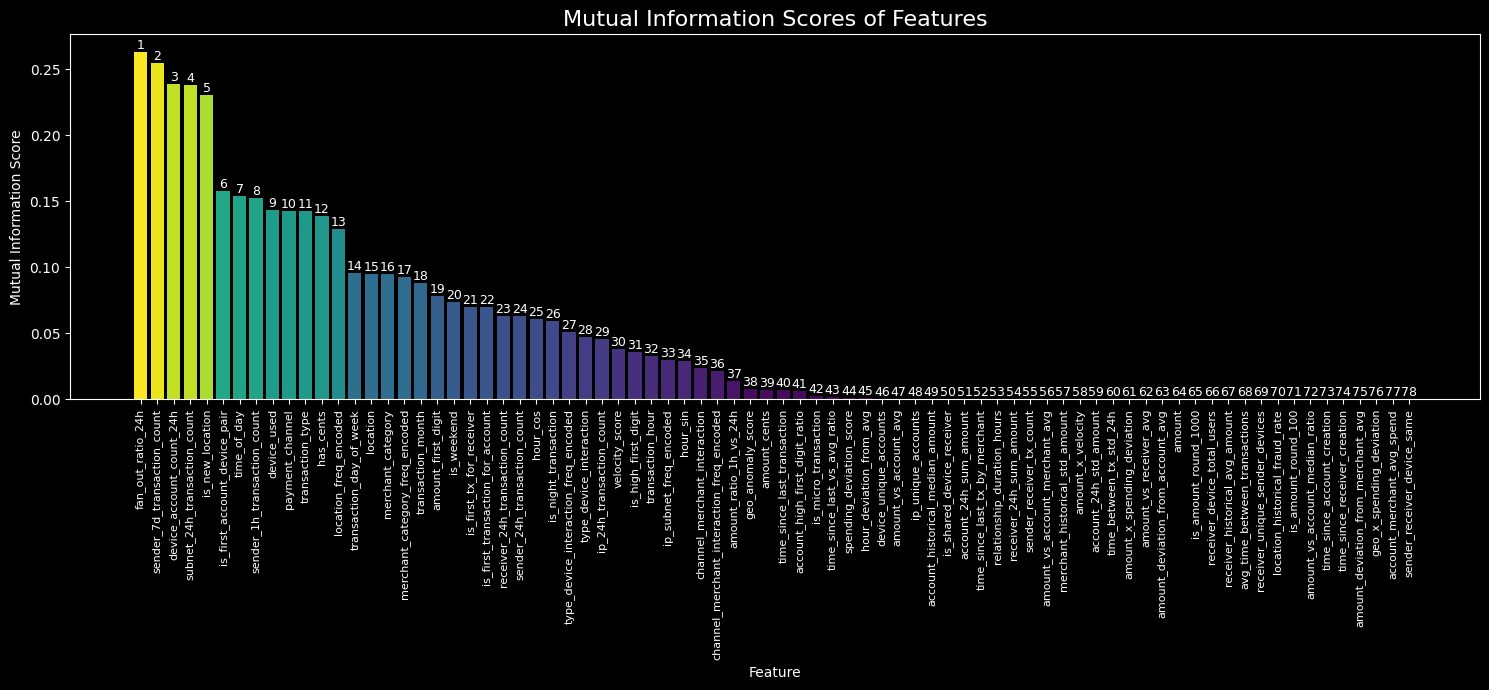

In [69]:
# Create the plot
plt.figure(figsize=(15, 7))

# Map scores to colors using the viridis colormap
norm = plt.Normalize(mi_scores['score'].min(), mi_scores['score'].max())
colors = plt.cm.viridis(norm(mi_scores['score']))

plt.bar(
    mi_scores['features'],
    mi_scores['score'],
    color=colors
)

# Formatting and annotations
plt.xticks(rotation=90, fontsize=8)
plt.ylabel('Mutual Information Score')
plt.xlabel('Feature')
plt.title('Mutual Information Scores of Features', fontsize=16)

# Add row number on top of each bar
for i, (feature, score) in enumerate(zip(mi_scores['features'], mi_scores['score'])):
    plt.text(i, score, str(i+1), ha='center', va='bottom', fontsize=9, color='white')

plt.tight_layout()
plt.show()

In [72]:
# Select the top 40 features
top_features = mi_scores.sort_values(by='score', ascending=False).head(40)['features'].tolist()

X_train_top_40 = X_train[top_features]
X_validation_top_40 = X_validation[top_features]
X_test_top_40 = X_test[top_features]

print(f"Selected {len(top_features)} features.")

Selected 40 features.


In [74]:
def objective(trial):
    # Hyperparameter search space
    params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1,
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 20, 30),
        
        # Core parameters for controlling complexity and learning
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        
        # Regularization and subsampling to prevent overfitting
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
    }

    # Train the model with the suggested hyperparameters
    model = lgb.LGBMClassifier(**params)
    
    model.fit(X_train_top_40, y_train,
              eval_set=[(X_validation_top_40, y_validation)],
              eval_metric='auc',
              callbacks=[lgb.early_stopping(100, verbose=False)])

    # Evaluate and return the score for Optuna to maximize
    preds = model.predict_proba(X_validation_top_40)[:, 1]
    aucpr_score = average_precision_score(y_validation, preds)
    
    return aucpr_score

# Create the study object
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# Print the best results
print("Best trial:")
trial = study.best_trial
print(f"  Value (AUCPR): {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-07-27 17:05:56,522] A new study created in memory with name: no-name-b390bb0d-bf92-4c3f-a7ee-16e620cbb646
[I 2025-07-27 17:06:24,034] Trial 0 finished with value: 0.04597542228834445 and parameters: {'scale_pos_weight': 28.355777152024274, 'learning_rate': 0.013471598523330741, 'n_estimators': 1946, 'num_leaves': 40, 'max_depth': 8, 'feature_fraction': 0.9249616920275088, 'bagging_fraction': 0.9497267251980627, 'bagging_freq': 7, 'lambda_l1': 0.07778283827481726, 'lambda_l2': 0.0008434544195671655}. Best is trial 0 with value: 0.04597542228834445.
[I 2025-07-27 17:06:38,825] Trial 1 finished with value: 0.04586159347502764 and parameters: {'scale_pos_weight': 28.88107264034512, 'learning_rate': 0.07960759696475898, 'n_estimators': 911, 'num_leaves': 39, 'max_depth': 15, 'feature_fraction': 0.8192664207174439, 'bagging_fraction': 0.5404423303002114, 'bagging_freq': 4, 'lambda_l1': 5.306255453279218e-08, 'lambda_l2': 1.9584437216880254e-07}. Best is trial 0 with value: 0.04597542

Best trial:
  Value (AUCPR): 0.046451154140390444
  Params: 
    scale_pos_weight: 21.263919745289034
    learning_rate: 0.02748720566285462
    n_estimators: 873
    num_leaves: 90
    max_depth: 6
    feature_fraction: 0.7050236504948113
    bagging_fraction: 0.9167622809152944
    bagging_freq: 3
    lambda_l1: 2.1521897048611566e-05
    lambda_l2: 2.4372317501199514e-07
